## Import Package

In [34]:
# required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numba as nb
import warnings
from datetime import datetime
import gc

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample

# display set up
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 3)
pd.options.display.max_rows = 999

## Load Data

In [2]:
# Functions for memory reduction
@nb.jit()
def reduce_mem_usage(df, verbose=True):
    """
    Helper function to reduce dataframe size.
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return(df)

In [ ]:
def load_data(filepath):
    df = pd.read_csv(filepath)
    df = reduce_mem_usage(df)
    print(f"Number of rows: {len(df)}".format(len(df)))
    print(f"Number of columns: {len(df.columns)-1} \n")
    return df

In [4]:
%%time

prop_2016 = load_data('data/prop_2016_v2.csv')
prop_2017 = load_data('data/prop_2017_v2.csv')
train = load_data('data/train_v2.csv')

Mem. usage decreased to 999.27 Mb (75.6% reduction)
Mem. usage decreased to 999.27 Mb (75.6% reduction)
Mem. usage decreased to 58.44 Mb (75.3% reduction)
CPU times: user 4min 28s, sys: 3min 10s, total: 7min 38s
Wall time: 9min


## Modeling Prep

In [5]:
%%time
def encoding(train, prop_2016, prop_2017, categorical_features):
    """
    To limit the value to small numbers since values in categorical_feature is suggested to be small.
    Now the number denoting missing values will be 0 instead of -1.
    """
    from category_encoders import BinaryEncoder
    
    split_index = [len(train), len(prop_2016), len(prop_2017)]
    
    
    prop = pd.concat([train[categorical_features],
                      prop_2016[categorical_features], 
                      prop_2017[categorical_features]], ignore_index=True)
    
    encoder = BinaryEncoder(cols=categorical_features, drop_invariant = True)
    transformed = encoder.fit_transform(prop)
    train_be = transformed.iloc[: split_index[0]].reset_index(drop=True)
    prop_2016_be = transformed.iloc[split_index[0] : split_index[0]+split_index[1]].reset_index(drop=True)
    prop_2017_be = transformed.iloc[split_index[0]+split_index[1]:].reset_index(drop=True)
    

    train = pd.concat([train.drop(columns=categorical_features).reset_index(drop=True), train_be], axis = 1)
    prop_2016 = pd.concat([prop_2016.drop(columns=categorical_features).reset_index(drop=True), prop_2016_be], axis = 1)
    prop_2017 = pd.concat([prop_2017.drop(columns=categorical_features).reset_index(drop=True), prop_2017_be], axis = 1)

    
    del prop, transformed, train_be, prop_2016_be, prop_2017_be
    gc.collect()
    return(train, prop_2016, prop_2017)

# Do encoding for cateogircal features
categorical_features = ['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid',
              'fips', 'heatingorsystemtypeid', 'propertycountylandusecode', 'propertylandusetypeid',
              'propertyzoningdesc', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip',
              'storytypeid', 'typeconstructiontypeid', 'geo_cluster']

train, prop_2016, prop_2017 = encoding(train, prop_2016, prop_2017, categorical_features)

CPU times: user 1min 38s, sys: 1min 29s, total: 3min 7s
Wall time: 3min 46s


In [6]:
# Transform to Numpy matrices
X = train.drop(columns=['logerror', 'parcelid', 'transactiondate'])
y = train.logerror.values


# Perform shuffled train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_test.shape))
print("y_val shape: {}".format(y_test.shape))

X_train shape: (134310, 214)
y_train shape: (134310,)
X_val shape: (33578, 214)
y_val shape: (33578,)


## Hyperparameter Tuning

We will conduct bayesian hyperparameter tuning with the help of the package `HyperOpt`

In [46]:
params= {
    'max_depth': hp.choice('max_depth', np.arange(1, 15+1, dtype=int)),
    'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(2, 15+1, dtype=int)),
    'min_samples_split': hp.choice('min_samples_split', np.arange(2, 15+1, dtype=int)),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', np.arange(2, 15+1, dtype=int)),
    'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.000001, 0.01)}

In [47]:
def tuning_hyperparam_lgb(X, y, num_eval, metric = mean_absolute_error, param = params):
    """
    Wrapper Function for the entire bayesian hyperparameter tuning process. 
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    
    # tuning hyperparameter
    print("Tuning hyperparameter for the output model.")
    t = datetime.now()
    results_hyperopt = hyperopt(param, X_train, y_train, X_test, y_test, num_eval)
    
    # Retrieve Hyperopt scores
    hyperopt_scores = [trial['result']['loss']*-1 for trial in results_hyperopt.trials]
    hyperopt_scores = np.maximum.accumulate(hyperopt_scores)
    
    # plotting
    plot_learning_curve(hyperopt_scores, num_eval = num_eval)
    
    # retrieve best results
    best = results_hyperopt.best_trial['misc']['vals']
    
    clf = RandomForestRegressor(n_estimators=10,
                                max_depth = np.int(best['max_depth'][0]),
                                min_samples_leaf = np.int(best['min_samples_leaf'][0]),
                                min_samples_split = np.int(best['min_samples_split'][0]),
                                max_leaf_nodes = np.int(best['max_leaf_nodes'][0]),
                                min_impurity_decrease = np.float(best['min_impurity_decrease'][0]),
    )
    
    print("Complete.")
    print(f"Time used: {datetime.now() - t}")
    print("")
    return(clf)

In [48]:
def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    """
    Main hyperparameter tuning function.
    """
    start = time.time()
    
    def objective_function(params):
        clf = RandomForestRegressor(**params).fit(X_train, y_train)
        pred = clf.predict(X_test)
        return {'loss': mean_absolute_error(y_test, pred), 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials)    
    return(trials)

In [49]:
def plot_learning_curve(hyperopt_scores, num_eval):
    """
    Plot hyperparameter learning curve.
    """
    f, ax = plt.subplots(figsize=(7,6))
    sns.set_palette("husl")
    sns.despine()
    ax = sns.lineplot(x=[x for x in range(num_eval)], y=hyperopt_scores, linewidth = 2)
    plt.title("Finding the optimum", fontsize=18)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Cross-Validation Score (accuracy, %)', fontsize=12)
    plt.legend(loc='lower right', labels=['Hyperopt'])
    plt.setp(ax.get_legend().get_texts(), fontsize='12')

Tuning hyperparameter for the output model.
100%|██████████| 10/10 [03:29<00:00, 20.97s/it, best loss: 0.06804927680638145]
Complete.
Time used: 0:03:29.798097



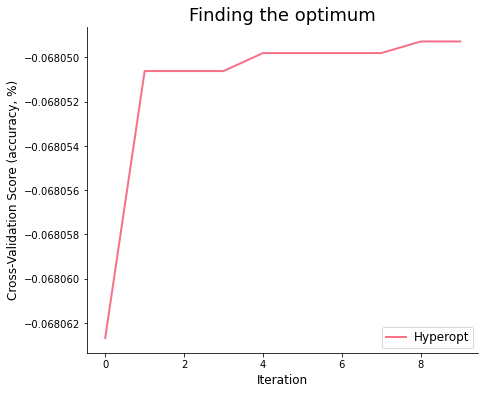

In [54]:
clf = tuning_hyperparam_lgb(X_train, y_train, num_eval=10)

In [55]:
params = clf.get_params()
params

{'bootstrap': True,
 'ccp_alpha': 0.0000,
 'criterion': 'mse',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 9,
 'max_samples': None,
 'min_impurity_decrease': 0.0051,
 'min_impurity_split': None,
 'min_samples_leaf': 6,
 'min_samples_split': 12,
 'min_weight_fraction_leaf': 0.0000,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Training on all Data

In [58]:
# Train multiple models
iterations = 3
models = []
params = clf.get_params()
params['n_estimators'] = 100
params['verbose'] = 2
for i in range(iterations):
    print("Start training model {}".format(i))
    params['random_state'] = (i+1)*100
    model = RandomForestRegressor(**params)
    model.fit(X, y)
    models.append(model)
    
# Sanity check (make sure scores on a small portion of the dataset are reasonable)
for i, model in enumerate(models):
    print("model {}: {}".format(i, abs(model.predict(X_test) - y_test).mean() * 100))

Start training model 0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   57.5s finished


Start training model 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.0min finished


Start training model 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   59.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


model 0: 7.191401230321529
model 1: 7.191342800752031


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


model 2: 7.191235857471194


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [59]:
def transform_test_features(prop_2016, prop_2017):
    """
    Helper method that prepares prop_2016 and prop_2017 for prediction.
    """
    
    # Create three datetime columns that does not exist in those dataset
    prop_2016['year'] = 0
    prop_2017['year'] = 1
    
    prop_2016['month'] = 8 # randomly select one month
    prop_2017['month'] = 8 # randomly select one month
    
    prop_2016['quarter'] = 3 # randomly select one quarter
    prop_2017['quarter'] = 3 # randomly select one quarter
    
    # Reorder to maintain categorical indices
    prop_2016 = prop_2016[['year', 'month', 'quarter'] + list(prop_2016.columns[:-3])]
    prop_2017 = prop_2017[['year', 'month', 'quarter'] + list(prop_2017.columns[:-3])]
    prop_2016.drop(columns = ['parcelid'], inplace = True)
    prop_2017.drop(columns = ['parcelid'], inplace = True)
    return(prop_2016, prop_2017)

def predict_and_export(models, prop_2016, prop_2017, file_name):
    """
    Helper method to make predicition and export results to csv.
    """
    # Construct DataFrame for prediction results
    submission_2016 = pd.DataFrame()
    submission_2017 = pd.DataFrame()
    submission_2016['ParcelId'] = prop_2016.parcelid
    submission_2017['ParcelId'] = prop_2017.parcelid
    
    # Prepare dataset for prediction
    prop_2016, prop_2017 = transform_test_features(prop_2016, prop_2017)
    
    # Make Prediction across multiple models
    pred_2016, pred_2017 = [], []
    for i, model in enumerate(models):
        print("Start model {} (2016)".format(i))
        pred_2016.append(model.predict(prop_2016))
        print("Start model {} (2017)".format(i))
        pred_2017.append(model.predict(prop_2017))
    
    # Take average across all models
    mean_pred_2016 = np.mean(pred_2016, axis=0)
    mean_pred_2017 = np.mean(pred_2017, axis=0)
    
    # Formatting for submission
    submission_2016['201610'] = [float(format(x, '.4f')) for x in mean_pred_2016]
    submission_2016['201611'] = submission_2016['201610']
    submission_2016['201612'] = submission_2016['201610']

    submission_2017['201710'] = [float(format(x, '.4f')) for x in mean_pred_2017]
    submission_2017['201711'] = submission_2017['201710']
    submission_2017['201712'] = submission_2017['201710']
    
    submission = pd.merge(submission_2016,submission_2017, how='inner', on='ParcelId')
    submission.to_csv(file_name, index=False)
    print("Submission Successfully Created.")
    return(submission, pred_2016, pred_2017)

In [60]:
%%time
del train
gc.collect()

file_name = 'submission/final_rf_v2.csv'
submission, pred_2016, pred_2017 = predict_and_export(models, prop_2016, prop_2017, file_name)

Start model 0 (2016)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished


Start model 0 (2017)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished


Start model 1 (2016)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished


Start model 1 (2017)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished


Start model 2 (2016)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished


Start model 2 (2017)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


Submission Successfully Created.
CPU times: user 58.1 s, sys: 54.5 s, total: 1min 52s
Wall time: 2min 23s
